In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Read and check how the data looks
nvidia = pd.read_csv('NVIDIApricehistory.csv')
nvidia.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,25-Nov-24,141.99,142.05,135.82,136.02,136.02,"344,941,900"
1,22-Nov-24,145.93,147.16,141.10,141.95,141.95,"236,406,200"
2,21-Nov-24,149.35,152.89,140.70,146.67,146.67,"400,946,600"
3,20-Nov-24,147.41,147.56,142.73,145.89,145.89,"309,871,700"
4,19-Nov-24,141.32,147.13,140.99,147.01,147.01,"227,834,900"


In [3]:
# Droping the rows with missing values, fixing the date format and turning the Open column into a float64 dtype
nvidia = nvidia.dropna()
nvidia['Date'] = pd.to_datetime(nvidia['Date'], format='%d-%b-%y')
nvidia['Open'] = nvidia['Open'].astype('float64')

In [4]:
# Data type of the columns
nvidia.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
AdjClose            float64
Volume               object
dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

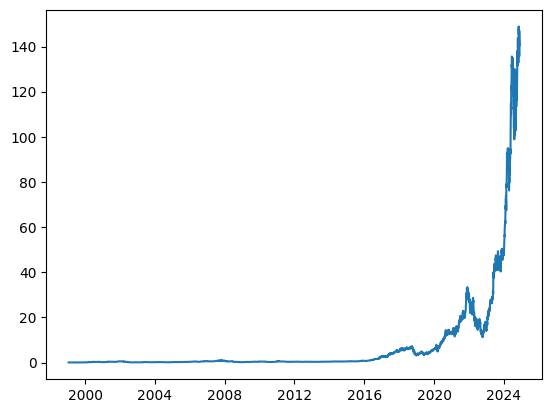

In [5]:
# Ploting the closing price over time
plt.plot(nvidia['Date'], nvidia['Close'])
plt.show

In [6]:
# Create the train and test datasets, for this example it is only going to take the closing price
data = nvidia[['Open', 'High',	'Low',	'Close']]

In [7]:
# Create a function to turn the data into time series data
def createTimeSeriesData(df, timesteps=1):
    columns = []
    for col in df.columns:
        for i in range(1, timesteps+1):
            columns.append(df[col].shift(i).rename(f"{col}_lag_{i}"))
    target = df.rename(columns=lambda col: f"{col}_target")
    ts_df = pd.concat(columns + [target], axis=1)
    ts_df.dropna(inplace=True)
    return ts_df

In [21]:
# Determine the number of timesteps (days to use in the prediction) and create the time series data
timesteps = 5
ts_data = createTimeSeriesData(data, timesteps)

In [23]:
# Split the data into features and targets (the last 4 columns of the dataframe are the targets)
X = ts_data.iloc[:, :-4].values  
y = ts_data.iloc[:, -4:].values  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define and train the MLP model (In this case the model has 4 outputs, Open, High, Low, Close)
mlp = MLPRegressor(hidden_layer_sizes=(10,5), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train, y_train)

# Make predictions
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))

print("Train RMSE for Open, High,  Low,  Close:", train_rmse)
print("Test RMSE for Open, High,  Low,  Close:", test_rmse)

Train RMSE for Open, High,  Low,  Close: [0.87337336 0.73461426 0.87351793 0.64618098]
Test RMSE for Open, High,  Low,  Close: [1.09939389 0.9516929  0.85425801 0.68055313]
